In [246]:
import pandas as pd

df = pd.read_csv('/home/n-grinsztajn/PycharmProjects/nature-go-wiki/data/useful_data/species_with_word_count.csv')

In [248]:
df_rarity = pd.read_csv('/home/n-grinsztajn/PycharmProjects/nature-go-wiki/data/useful_data/species_with_rarity2.csv')
rarity_columns = ['rarity_batch_0', 'rarity_batch_1', 'rarity_batch_2', 'rarity_batch_3', 'rarity_batch_4']
df_rarity['rarity_gpt'] = df_rarity[rarity_columns].mean(axis=1)


array([[<Axes: title={'center': 'rarity_gpt'}>]], dtype=object)

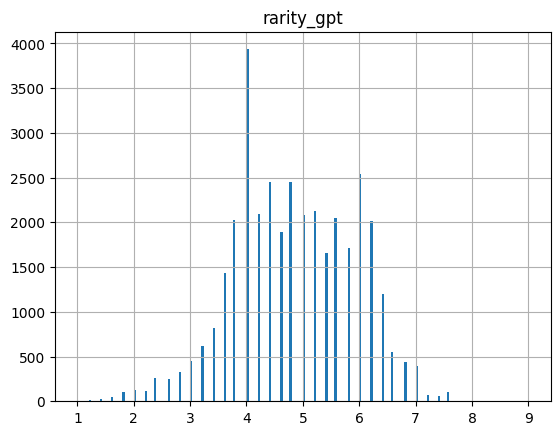

In [89]:
df_rarity.hist(column='rarity_gpt', bins=200)

In [249]:
full_df = pd.merge(df, df_rarity[['id', 'rarity_gpt']], on='id', how='inner')
full_df.rename(columns={'rarity_gpt': 'rarityGpt'}, inplace=True)

In [250]:
(full_df['WikipediaWordCount'] > 0).sum()


18433

In [253]:
df_legacy = pd.read_csv('/home/n-grinsztajn/PycharmProjects/nature-go-wiki/data/useful_data/plantnet_species_legacy.csv')
df_legacy = df_legacy.drop_duplicates(subset=['species'])


In [254]:
merged_df = pd.merge(full_df, df_legacy[['species', 'numberOfOccurrences']], how='left', left_on='scientificNameWithoutAuthor', right_on='species')
print(len(merged_df))
# Update numberOfOccurrences in df1
merged_df['numberOfOccurrences'] = merged_df['numberOfOccurrences'].fillna(-1)
print(len(merged_df))

36469
36469


In [255]:
sum(merged_df['numberOfOccurrences'] > 0)

14169

In [256]:
merged_df.drop(columns=['species'], inplace=True)

In [257]:
p_rarity = {'legendary': 0.01, 'rare': 0.10, 'uncommon': 0.20, 'common': 0.68}

# Sort the p_rarity dictionary by value in descending order
sorted_rarity = {k: v for k, v in sorted(p_rarity.items(), key=lambda item: item[1], reverse=True)}

merged_df['occurencePositif'] = merged_df['numberOfOccurrences'].replace(-1, 0)

merged_df = merged_df.sort_values(by='occurencePositif', ascending=False)
merged_df.reset_index(drop=True, inplace=True)

# Calculate the cumulative sum of 'numberOfOccurrences'
merged_df['cumulative_sum'] = merged_df['occurencePositif'].cumsum()
merged_df['occurences_cdf'] = 1 - merged_df['cumulative_sum'] / merged_df['occurencePositif'].sum()

# Calculate the total number of occurrences
total_occurrences = merged_df['occurencePositif'].sum()

# Initialize an empty dictionary to store the results
index_rarity = {}

# Initialize a variable to keep track of the cumulative percentage
cumulative_percent = 0

# Loop through each rarity level and find the corresponding index
for rarity, percent in sorted_rarity.items():
    cumulative_percent += percent
    index = merged_df[merged_df['cumulative_sum'] >= cumulative_percent * total_occurrences].index[0]
    index_rarity[rarity] = index

index_rarity

{'common': 510, 'uncommon': 1322, 'rare': 4120, 'legendary': 5964}

In [258]:
merged_df.drop(columns=['cumulative_sum', 'occurencePositif'], inplace=True)

In [90]:
merged_df.to_csv('data/species_final.csv', index=False)

In [ ]:
# get the discovery date + genus + family

In [259]:
import re

df = pd.read_csv("/home/n-grinsztajn/PycharmProjects/nature-go-wiki/data/wcvp_names.csv", delimiter='|', on_bad_lines='warn')
print(len(df))
df = df.loc[df['taxon_rank'] == 'Species']
# df = df.loc[df['taxon_status'] == 'Accepted']
print(len(df))

df['first_published_str'] = df['first_published'].astype(str)

# Use regular expressions to extract the first 4-digit number from each entry
df['first_published_cleaned'] = df['first_published_str'].apply(lambda x: int(re.search(r'\d{4}', x).group()) if re.search(r'\d{4}', x) else None)

# Drop rows where cleaned 'first_published' is None
df_cleaned = df.dropna(subset=['first_published_cleaned'])

# Convert to integers
df_cleaned['first_published_cleaned'] = df_cleaned['first_published_cleaned'].astype(int)

print(sum(df_cleaned['taxon_name'].duplicated()))

df_cleaned_no_duplicates = df_cleaned.loc[df['taxon_status'] == 'Accepted']
print(sum(df_cleaned_no_duplicates['taxon_name'].duplicated()))

Skipping line 684912: expected 31 fields, saw 35

/tmp/ipykernel_125926/3244673053.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/n-grinsztajn/PycharmProjects/nature-go-wiki/data/wcvp_names.csv", delimiter='|', on_bad_lines='warn')


1418847
1028579


/tmp/ipykernel_125926/3244673053.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['first_published_cleaned'] = df_cleaned['first_published_cleaned'].astype(int)


47558
0


In [260]:
df_cleaned['taxon_status'].value_counts()

taxon_status
Synonym              564112
Accepted             356364
Unplaced              39833
Illegitimate          39292
Invalid               23087
Orthographic           1679
Artificial Hybrid      1565
Misapplied             1102
Local Biotype          1090
Name: count, dtype: int64

In [96]:
merged_df.keys()

Index(['id', 'commonNames', 'scientificNameWithoutAuthor',
       'scientificNameAuthorship', 'gbifId', 'powoId', 'iucnCategory',
       'WikipediaWordCount', 'rarityGpt', 'numberOfOccurrences',
       'occurences_cdf'],
      dtype='object')

In [261]:
# df_final_final = pd.merge(merged_df, df_cleaned[['taxon_name', 'powo_id', 'family', 'genus', 'first_published_cleaned']], how='left', left_on='scientificNameWithoutAuthor', right_on='taxon_name')
df_final_final = pd.merge(merged_df, df_cleaned[['taxon_name', 'powo_id', 'family', 'genus', 'first_published_cleaned']], how='left', left_on='powoId', right_on='powo_id')

In [262]:
print(sum(df_final_final['powoId'].isna()))
print(sum(df_final_final['powo_id'].isna()))

1
9


In [216]:
df_final_final.keys()

Index(['id', 'commonNames', 'scientificNameWithoutAuthor',
       'scientificNameAuthorship', 'gbifId', 'powoId', 'iucnCategory',
       'WikipediaWordCount', 'rarityGpt', 'numberOfOccurrences',
       'occurences_cdf', 'taxon_name', 'powo_id', 'family', 'genus',
       'first_published_cleaned'],
      dtype='object')

In [264]:
na_rows = df_final_final[df_final_final['family'].isna()]
updated_na_rows = pd.merge(
    na_rows.drop(columns=['taxon_name', 'family', 'genus', 'first_published_cleaned', 'powo_id']),  # Drop conflicting columns
    df_cleaned[['taxon_name', 'powo_id', 'family', 'genus', 'first_published_cleaned']],
    how='left',
    left_on='scientificNameWithoutAuthor',
    right_on='taxon_name'
)
df_final_final = df_final_final.dropna(subset=['family'])
df_final_final = pd.concat([df_final_final, updated_na_rows], ignore_index=True)

print(sum(df_final_final['powoId'].isna()))
print(sum(df_final_final['powo_id'].isna()))


1
4


In [273]:
print(len(merged_df))
print(len(df_final_final))

36469
36469


In [271]:
df_final_final[df_final_final.duplicated(subset=['scientificNameWithoutAuthor'], keep=False)]

,id,commonNames,scientificNameWithoutAuthor,scientificNameAuthorship,gbifId,powoId,iucnCategory,WikipediaWordCount,rarityGpt,numberOfOccurrences,occurrencesCdf,powoIdReal,family,genus,firstPublished
36461,1376705,"['Kaduk Malaysia', 'Wild pepper', 'Lá lốt', 'S...",Piper sarmentosum,Roxb.,4191172.0,683277-1,NaN,641.0,3.6,5.0,0.008993,683278-1,Piperaceae,Piper,1810.0
36462,1376705,"['Kaduk Malaysia', 'Wild pepper', 'Lá lốt', 'S...",Piper sarmentosum,Roxb.,4191172.0,683277-1,NaN,641.0,3.6,5.0,0.008993,683276-1,Piperaceae,Piper,1832.0


In [272]:
# remove the duplicates where powoIdReal is 683278-1
indexes_to_drop = df_final_final[df_final_final['powoIdReal'] == '683278-1'].index
df_final_final.drop(indexes_to_drop, inplace=True)

In [275]:
df_final_final.drop(columns=['taxon_name'], inplace=True)

In [266]:
df_final_final.rename(columns={'first_published_cleaned': 'firstPublished'}, inplace=True)
df_final_final.rename(columns={'occurences_cdf': 'occurrencesCdf'}, inplace=True)
df_final_final.rename(columns={'powo_id': 'powoIdReal'}, inplace=True)

In [239]:
df_final_final.keys()

Index(['id', 'commonNames', 'scientificNameWithoutAuthor',
       'scientificNameAuthorship', 'gbifId', 'powoId', 'iucnCategory',
       'WikipediaWordCount', 'rarityGpt', 'numberOfOccurrences',
       'occurrencesCdf', 'powoIdReal', 'family', 'genus', 'firstPublished'],
      dtype='object')

In [277]:
df_final_final.to_csv('data/species.csv', index=False)

In [121]:
sum(df_rarity['powoId'].isna())

1

In [124]:
sum(df['powoId'].isna())

1

In [125]:
pd_species = pd.read_csv('/home/n-grinsztajn/PycharmProjects/nature-go-wiki/data/species.csv')

In [241]:
sum(pd_species['powoId'].isna())

1

In [127]:
sum(full_df['powoId'].isna())

1

In [133]:
sum(merged_df['powoId'].isna())

1

In [142]:
print(sum(df_cleaned['powo_id'].isna()))
print(sum(df_cleaned['family'].isna()))

0
0


In [180]:
sum(df_final_final['powoId'].isna())

1

In [153]:
df_cleaned[df_cleaned['taxon_name'] == "Dentella repens"]['powo_id']

1199034    748286-1
Name: powo_id, dtype: object

In [154]:
pd_species[pd_species['scientificNameWithoutAuthor'] == "Dentella repens"]['powoId']

28485    748287-1
Name: powoId, dtype: object

In [229]:
pd_species['gbifId'].isna().sum()

38

## Dataset analysis

In [2]:
import pandas as pd
import numpy as np


df = pd.read_csv('data/species.csv')

df['WikipediaWordCount'].sum()

5925578.0

In [280]:
# Whay's the cost if all that goes into the GPT-3 model?

df['WikipediaWordCount'].sum() / 1000 * 0.002



11.851156000000001

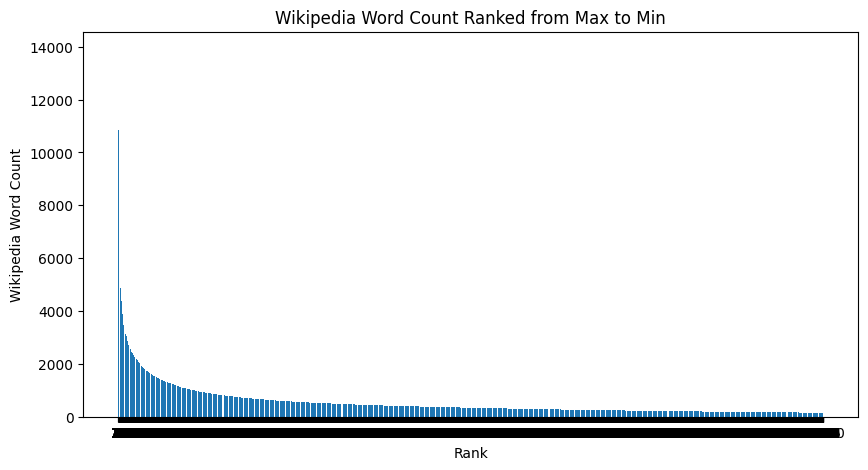

In [7]:
# plot ranked WikipediaWordCount
import matplotlib.pyplot as plt
import numpy as np

df_sorted = df.sort_values(by='WikipediaWordCount', ascending=False)
df_sorted.reset_index(drop=True, inplace=True)
df_sorted = df_sorted[:10000]

plt.figure(figsize=(10, 5))
plt.bar(df_sorted.index, df_sorted['WikipediaWordCount'])
plt.xlabel('Rank')
plt.xticks(df_sorted.index, df_sorted.index + 1)  # Adding 1 to start the ranking from 1 instead of 0
plt.ylabel('Wikipedia Word Count')
plt.title('Wikipedia Word Count Ranked from Max to Min')
plt.show()


In [283]:
# Which species have the highest WikipediaWordCount?
df_final_final.sort_values(by='WikipediaWordCount', ascending=False).head(10)

,id,commonNames,scientificNameWithoutAuthor,scientificNameAuthorship,gbifId,powoId,iucnCategory,WikipediaWordCount,rarityGpt,numberOfOccurrences,occurrencesCdf,powoIdReal,family,genus,firstPublished
26277,1388987,"['Florida torreya', 'Gopherwood', 'Stinking-ce...",Torreya taxifolia,Arn.,5284481.0,264000-1,CR,13877.0,7.0,-1.0,0.000000,264000-1,Taxaceae,Torreya,1838.0
1658,1385873,"['Coconut palm', 'Coconut', 'नारियल', 'Copra',...",Cocos nucifera,L.,2735117.0,666160-1,NaN,10854.0,1.6,124.0,0.088139,666160-1,Arecaceae,Cocos,1753.0
1069,1363500,"['Corn', 'Sweet Corn', 'Maize', 'Indian corn',...",Zea mays,L.,5290052.0,426810-1,LC,10005.0,1.4,276.0,0.155632,426810-1,Poaceae,Zea,1753.0
1453,1362626,"[""Elephant's-ear"", 'Taro', 'بابا آدم', 'Elepha...",Colocasia esculenta,(L.) Schott,5330776.0,1170772-2,LC,9170.0,2.2,160.0,0.105871,1170772-2,Araceae,Colocasia,1832.0
2616,1366904,"['Soybean', 'Soya', 'Soya-bean', 'Edamame', 'R...",Glycine max,(L.) Merr.,5359660.0,60450240-2,NaN,8254.0,4.4,46.0,0.043647,60450240-2,Fabaceae,Glycine,1917.0
34826,1720972,['Small Japanese Silver grass'],Miscanthus × longiberbis,(Hack.) Nakai,4149689.0,408749-1,NaN,7562.0,5.8,-1.0,0.000000,408749-1,Poaceae,Miscanthus,1917.0
3405,1356171,"['Potato', 'Irish potato', 'Aéstomemésêhestôts...",Solanum tuberosum,L.,2930262.0,821337-1,NaN,7506.0,2.0,23.0,0.027971,821337-1,Solanaceae,Solanum,1753.0
228,1359676,"['Olive', 'زیتون', 'Oliveleaf', 'Small-fruit o...",Olea europaea,L.,5415040.0,610675-1,NaN,6854.0,2.8,1742.0,0.525610,610675-1,Oleaceae,Olea,1753.0
9726,1389265,"['Calico Aster', 'Calico Or One-Sided Or White...",Symphyotrichum lateriflorum,(L.) Á.Löve & D.Löve,7832723.0,247115-2,NaN,6821.0,3.4,2.0,0.002934,247115-2,Asteraceae,Symphyotrichum,1982.0
1945,1396325,"['Garden tomato', 'Tomato', 'Cherry Tomatoes',...",Solanum lycopersicum,L.,2930137.0,316947-2,NaN,6718.0,1.4,87.0,0.069839,316947-2,Solanaceae,Solanum,1753.0
